## Lesson 5. Join Attributes From One Shapefile to Another

In [73]:
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
from shapely.geometry import box
import geopandas as gpd
import earthpy as et

In [74]:
data_path = et.data.get_data('spatial-vector-lidar')

In [75]:
country_bdy_us = gpd.read_file(os.path.join(data_path,
                                            'usa',
                                            'usa-boundary-dissolved.shp'))
state_bdy_us = gpd.read_file(os.path.join(data_path,
                                          'usa',
                                          'usa-states-census-2014.shp'))
pop_places = gpd.read_file(os.path.join(data_path,
                                        'global',
                                        'ne_110m_populated_places_simple',
                                        'ne_110m_populated_places_simple.shp'))
ne_roads = gpd.read_file(os.path.join(data_path,
                                      'global',
                                      'ne_10m_roads',
                                      'ne_10m_roads.shp'))

Simplify the country boundary a bit to make this run faster

In [76]:
country_bdy_us_simp = country_bdy_us.simplify(0.2, preserve_topology=True)

In [77]:
%%time
roads_cl_simp = gpd.clip(ne_roads, country_bdy_us_simp)

Wall time: 2.69 s


In [78]:
%%time
roads_cl = gpd.clip(ne_roads, country_bdy_us)

Wall time: 15.6 s


Based on the above I don't mind using the non-simplified boundary.

In [79]:
roads_cl.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [80]:
ne_roads.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Both CRS are already the same so need to use <code>roads_cl.crs = ne_road.crs</code> like in the textbook.

Now dissolve the states by region

In [81]:
regions_agg = state_bdy_us.dissolve(by='region')

In [82]:
regions_agg

,geometry,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER
region,,,,,,,,,,
Midwest,"MULTIPOLYGON Z (((-87.80048 42.49192 0.00000, ...",17,01779784,0400000US17,17,IL,Illinois,00,143794747023,6200927458
Northeast,"MULTIPOLYGON Z (((-76.04621 38.02553 0.00000, ...",11,01702382,0400000US11,11,DC,District of Columbia,00,158350578,18633500
Southeast,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ...",12,00294478,0400000US12,12,FL,Florida,00,138903200855,31407883551
Southwest,"POLYGON Z ((-94.48587 33.63787 0.00000, -94.41...",48,01779801,0400000US48,48,TX,Texas,00,676601887070,19059877230
West,"MULTIPOLYGON Z (((-104.05325 41.00141 0.00000,...",06,01779778,0400000US06,06,CA,California,00,403483823181,20483271881


**Spatial Joins**

Roads within region

In [83]:
roads_region = gpd.sjoin(roads_cl,
                         regions_agg,
                         how='inner',
                         op='intersects')
roads_region.head()

,scalerank,featurecla,type,sov_a3,note,edited,name,namealt,namealtt,routeraw,...,index_right,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER
1,7,Road,Secondary Highway,USA,None,"Version 1.5: Changed alignment, a few adds in ...",83,None,None,None,...,Midwest,17,01779784,0400000US17,17,IL,Illinois,00,143794747023,6200927458
3,8,Road,Secondary Highway,USA,None,"Version 1.5: Changed alignment, a few adds in ...",151,None,None,None,...,Midwest,17,01779784,0400000US17,17,IL,Illinois,00,143794747023,6200927458
6,8,Road,Secondary Highway,USA,None,"Version 1.5: Changed alignment, a few adds in ...",85,None,None,None,...,Midwest,17,01779784,0400000US17,17,IL,Illinois,00,143794747023,6200927458
7,8,Road,Secondary Highway,USA,None,"Version 1.5: Changed alignment, a few adds in ...",85,None,None,None,...,Midwest,17,01779784,0400000US17,17,IL,Illinois,00,143794747023,6200927458
54,6,Road,Secondary Highway,USA,None,"Version 1.5: Changed alignment, a few adds in ...",2,None,None,None,...,Midwest,17,01779784,0400000US17,17,IL,Illinois,00,143794747023,6200927458


In [84]:
roads_cl.head(2)

,scalerank,featurecla,type,sov_a3,note,edited,name,namealt,namealtt,routeraw,...,rwdb_rd_id,orig_fid,prefix,uident,continent,expressway,level,min_zoom,min_label,geometry
1,7,Road,Secondary Highway,USA,None,"Version 1.5: Changed alignment, a few adds in ...",83,None,None,None,...,0,0,None,108105,North America,0,Federal,7.0000,8.6000,"LINESTRING Z (-100.50543 42.80753 0.00000, -10..."
2,7,Road,Secondary Highway,USA,None,"Version 1.5: Changed alignment, a few adds in ...",840,None,None,None,...,0,0,None,0,North America,0,U/C,7.0000,9.5000,"LINESTRING Z (-87.27432 36.02439 0.00000, -87...."


In [85]:
regions_agg.head(2)

,geometry,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER
region,,,,,,,,,,
Midwest,"MULTIPOLYGON Z (((-87.80048 42.49192 0.00000, ...",17,01779784,0400000US17,17,IL,Illinois,00,143794747023,6200927458
Northeast,"MULTIPOLYGON Z (((-76.04621 38.02553 0.00000, ...",11,01702382,0400000US11,11,DC,District of Columbia,00,158350578,18633500


In [86]:
for column in roads_region.columns:
    if not(column in roads_cl.columns):
        print(column)

index_right
STATEFP
STATENS
AFFGEOID
GEOID
STUSPS
NAME
LSAD
ALAND
AWATER


Reproject to Albers for plotting

In [87]:
country_albers = country_bdy_us.to_crs(epsg = 5070)
roads_region_albers = roads_region.to_crs(epsg = 5070)

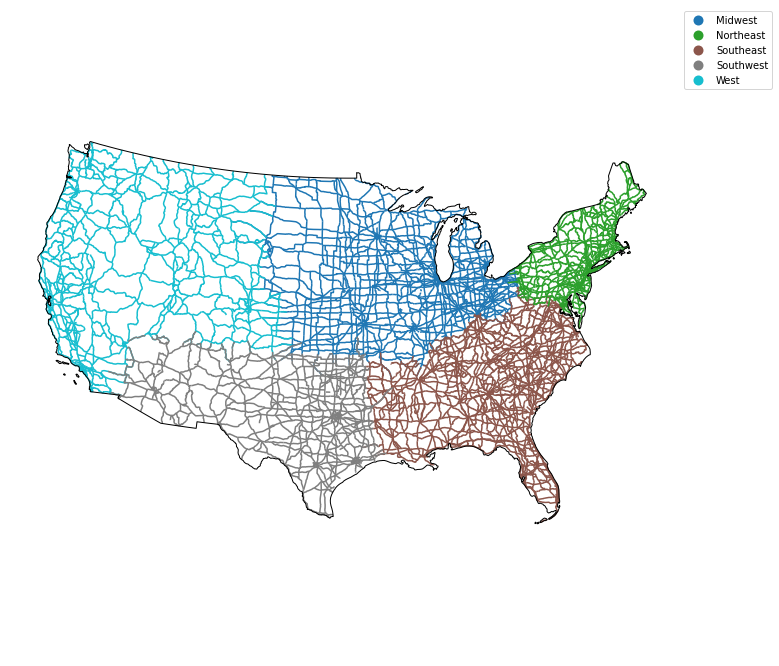

In [88]:
fig, ax = plt.subplots(figsize=(12,12))

country_albers.plot(ax=ax,
                    alpha=1,
                    zorder=10,
                    facecolor='none',
                    edgecolor='black')
roads_region_albers.plot(ax=ax,
                         column='index_right',
                         legend=True)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15,1))
plt.axis('equal')
ax.set_axis_off()
plt.show()

Now customise the legend

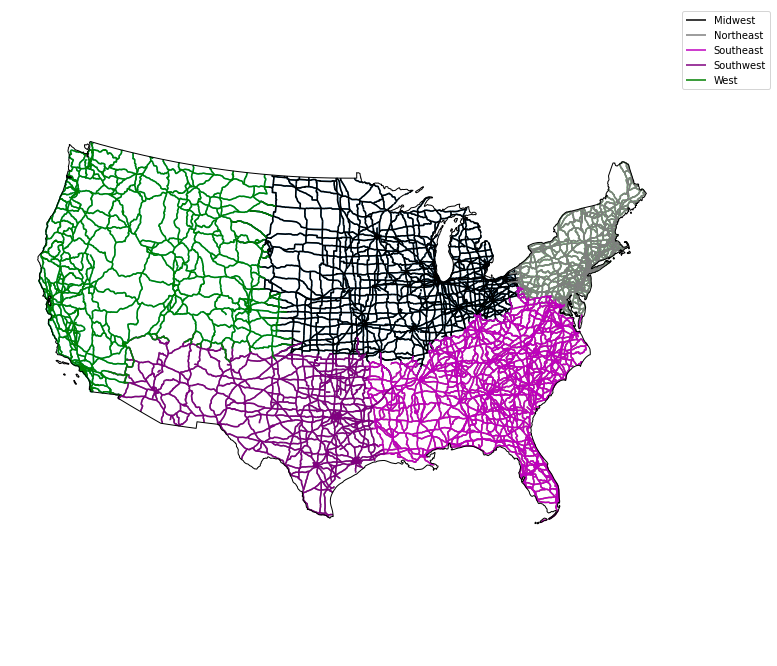

In [89]:
roads_attrs = {'Midwest': ['black'],
               'Northeast': ['grey'],
               'Southeast': ['m'],
               'Southwest': ['purple'],
               'West': ['green']}

fig, ax = plt.subplots(figsize=(12,12))

country_albers.plot(ax=ax,
                    alpha=1,
                    zorder=10,
                    facecolor='none',
                    edgecolor='black')
roads_region_albers.plot(ax=ax,
                         column='index_right',
                         legend=True)

for ctype, data in roads_region_albers.groupby('index_right'):
    data.plot(color=roads_attrs[ctype][0],
              ax=ax,
              label=ctype)

plt.legend(bbox_to_anchor=(1.0,1), loc=2)
plt.axis('equal')
ax.set_axis_off()
plt.show()

**Calculate Line Length Segment**

Turn off scientific notation

In [90]:
pd.options.display.float_format = '{:.4f}'.format

In [91]:
roads_region_albers_length = roads_region_albers[['index_right', 'length_km']]
roads_region_albers_length

,index_right,length_km
1,Midwest,164
3,Midwest,17
6,Midwest,138
7,Midwest,54
54,Midwest,258
...,...,...
53723,Southwest,16
53796,Southwest,54
53797,Southwest,110
53803,Southwest,20


In [92]:
roads_region_albers_length.groupby(['index_right']).sum()

,length_km
index_right,
Midwest,95585
Northeast,37825
Southeast,87151
Southwest,51928
West,66383


The <code>.length</code> attribute deosn't exist below because there are no <code>shapely</code> objects (i.e. geometries) in the gdf.

In [94]:
roads_region_albers_length.length

AttributeError: 'DataFrame' object has no attribute 'length'

In [95]:
roads_region_albers['length_km']

1        164
3         17
6        138
7         54
54       258
        ... 
53723     16
53796     54
53797    110
53803     20
53805     10
Name: length_km, Length: 7509, dtype: int64

In [96]:
type(roads_region_albers.length)

pandas.core.series.Series

Trying the texbook code because it doesn't make sense (edit: it does)

In [97]:
# Turn off scientific notation
pd.options.display.float_format = '{:.4f}'.format

# Calculate the total length of road 
road_region_albers_length = roads_region_albers[['index_right', 'length_km']]

road_region_albers_length

,index_right,length_km
1,Midwest,164
3,Midwest,17
6,Midwest,138
7,Midwest,54
54,Midwest,258
...,...,...
53723,Southwest,16
53796,Southwest,54
53797,Southwest,110
53803,Southwest,20


<code>.length</code> is a shapely method available geodataframes that calculates the Euclidean (i.e. not on a geoid) of a geometry in m

In [98]:
# Sum existing columns
roads_region_albers.groupby('index_right').sum()

,scalerank,question,length_km,toll,labelrank,ignore,add,rwdb_rd_id,orig_fid,uident,expressway,min_zoom,min_label,ALAND,AWATER
index_right,,,,,,,,,,,,,,,
Midwest,12988,0,95585,30,0,0,0,0,2870579,85405553,424,12374.2000,17316.0000,278242835489505,11998794631230
Northeast,8639,0,37825,87,0,0,0,0,2976858,53416044,344,8171.0000,11466.5000,201738636372,23739079000
Southeast,16328,0,87151,37,0,0,0,0,3712967,132275923,428,15464.9000,21524.4000,327811554017800,74122605180360
Southwest,5879,0,51928,32,0,0,0,0,1540638,83861025,202,5659.4000,7788.3000,608265096475930,17134829629770
West,6506,0,66383,21,0,0,0,0,627887,50577518,319,6281.9000,8398.2000,420026659931421,21323086028121


In [100]:
roads_region_albers['rdlength'] = roads_region_albers.length

The above line does nothing. I don't know why it's there.

In [99]:
sub = roads_region_albers[['rdlength', 'index_right']].groupby('index_right').sum()
sub

,rdlength
index_right,
Midwest,87070868.1488
Northeast,34484959.9799
Southeast,84704963.4762
Southwest,49478302.4104
West,61936820.6737


The above distances are euclidean lengths of the road geometries in m.